# CNN - 1D - Toxic Comments

A corpus of manually labeled comments - classifying each comment by its type of toxicity is available on Kaggle. We will aim to do a binary classification of whether a comment is toxic or not

Approach:
- Learning Embedding with the Task
- 1D - Convolution Neural Networks to model the sequence data

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import vis

Using TensorFlow backend.


### Get the Data

Uncomment these shell lines to get the data

In [2]:
# !wget http://bit.do/deep_toxic_train -P data/
# !mv data/deep_toxic_train data/train.zip

In [3]:
df = pd.read_csv("data/train.zip")

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Import the required libraries

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### Create the Input & Output Data

In [6]:
train_sentences = df["comment_text"]
train_sentences.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

**Pre-processing the train data**
- Tokenization: "This is an apple" -> ["This", "is", "an", "apple"]
- Indexing: {0: "This", 1: "is", 2: "an", 3: "apple"}
- Index Representation: [0, 1, 2, 3]

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [8]:
# Tokenizer
max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')
tokenizer.fit_on_texts(list(train_sentences))

Tokenizer Fix from https://github.com/keras-team/keras/issues/8092

In [9]:
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = max_words + 1

In [10]:
# Index Representation
tokenized_train = tokenizer.texts_to_sequences(train_sentences)

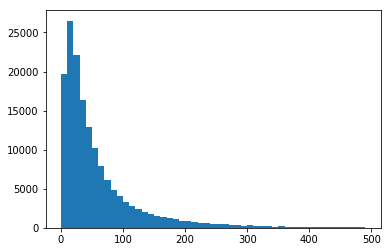

In [11]:
# Selecting Padding
# find length of each sentence and plot the length
number_of_words = [len(comment) for comment in tokenized_train]
plt.hist(number_of_words, bins = np.arange(0, 500, 10));

In [12]:
# Padding to make it uniform
maxlen = 200
X = pad_sequences(tokenized_train, maxlen = maxlen)

In [13]:
labels = df.iloc[:,2].values

In [14]:
# Baseline Benchmark 
1 - df.iloc[:,2].sum()/df.iloc[:,2].count()

0.9041555169799024

In [15]:
from keras.utils import to_categorical
y = to_categorical(labels)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127656, 200), (31915, 200), (127656, 2), (31915, 2))

### Step 2: Create the Model Architecture

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding, Dropout

In [19]:
model = Sequential()
model.add(Embedding(max_words, output_dim=128))
model.add(Conv1D(128, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(2, activation='sigmoid'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

### Step 3: Compile the Model & Fit on the Data

In [21]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [22]:
output = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 26s 252us/step - loss: 0.1941 - acc: 0.9332 - val_loss: 0.1595 - val_acc: 0.9442
Epoch 2/5
102124/102124 [==============================] - 21s 201us/step - loss: 0.1501 - acc: 0.9483 - val_loss: 0.1572 - val_acc: 0.9468
Epoch 3/5
102124/102124 [==============================] - 21s 201us/step - loss: 0.1388 - acc: 0.9514 - val_loss: 0.1584 - val_acc: 0.9461
Epoch 4/5
102124/102124 [==============================] - 21s 204us/step - loss: 0.1260 - acc: 0.9560 - val_loss: 0.1679 - val_acc: 0.9412
Epoch 5/5
102124/102124 [==============================] - 21s 202us/step - loss: 0.1117 - acc: 0.9614 - val_loss: 0.1706 - val_acc: 0.9454


### Step 4: Evaluate the Model

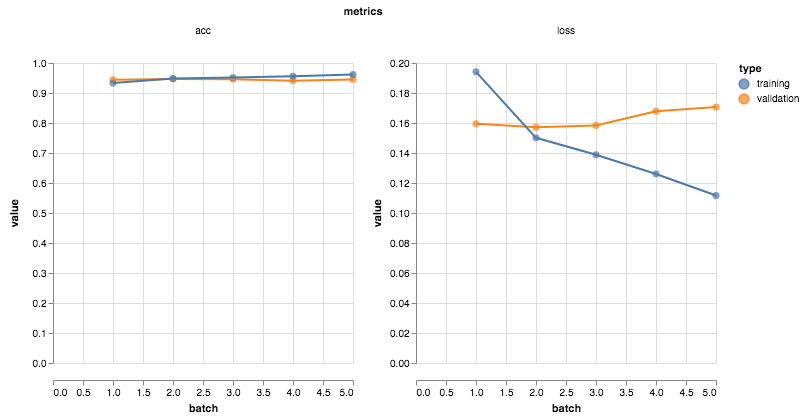

In [23]:
vis.metrics(output.history)

In [24]:
score = model.evaluate(X_test, y_test, verbose=1)

31915/31915 [==============================] - 3s 103us/step


In [25]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17662850376192293
Test accuracy: 0.9449788500704998


### Step 5: Visualise evaluation & Make a prediction

In [26]:
predict_classes = model.predict_classes(X_test)

In [27]:
actual_classes = np.dot(y_test,np.array([[0],[1]])).reshape(-1)

In [28]:
pd.crosstab(actual_classes, predict_classes)

col_0,0,1
row_0,,
0.0,28395,464
1.0,1289,1767
